# Dades de la primera setmana

In [1]:
from elasticsearch import Elasticsearch
import json

# Define config
host = "my-elasticsearch"
username= 'elastic'
password= 'password'
port = 9200
timeout = 1000

# Init Elasticsearch instance
es = Elasticsearch(
    [{'host': host, 'port': port}],
    timeout=timeout,
    http_auth=(username, password)
)
es.info()

{'name': 'my-elasticsearch',
 'cluster_name': 'docker-cluster',
 'cluster_uuid': 'TrnE0Z3ZRh2tnvlxwDa-Yw',
 'version': {'number': '7.10.1',
  'build_flavor': 'default',
  'build_type': 'docker',
  'build_hash': '1c34507e66d7db1211f66f3513706fdf548736aa',
  'build_date': '2020-12-05T01:00:33.671820Z',
  'build_snapshot': False,
  'lucene_version': '8.7.0',
  'minimum_wire_compatibility_version': '6.8.0',
  'minimum_index_compatibility_version': '6.0.0-beta1'},
 'tagline': 'You Know, for Search'}

In [3]:
index = 'tfg-*'
body = {
    "query": {
        "range": {
            "created_at": {
                "gte": "2019-12-02T00:00:00.000Z",
                "lt": "2019-12-09T00:00:00.000Z"
            }
        }
    }
}
size = 25
dataset = []

def process_hits(hits):
    for hit in hits:
        item = {} 
        item['_id'] = hit['_id']
        item['_type'] = hit['_type']
        item['_index'] = hit['_index']
        for k in hit['_source'].keys():
            if k == 'diputado':
                continue
            item[k] = hit['_source'][k]
        
        for k in hit['_source']['diputado'].keys():
            item[f'diputado.{k}'] = hit['_source']['diputado'][k]
        dataset.append(item)

# init scroll by scan
data = es.search(
    index=index,
    scroll='2m',
    size=size,
    body=body
)

sid = data['_scroll_id']
scroll_size = len(data['hits']['hits'])

while scroll_size > 0:    
    # before scroll, process current batch of hits
    process_hits(data['hits']['hits'])
    
    data = es.scroll(scroll_id=sid, scroll='2m')
    
    
    # Update the scroll ID
    sid = data['_scroll_id']
    # Get the number of results that returned in the last scroll
    scroll_size = len(data['hits']['hits'])

print(len(dataset))

144


In [4]:
dataset[24]

{'_id': 'H-0To3gBIirSknWciRnx',
 '_type': '_doc',
 '_index': 'tfg-tweets',
 'id': '1203771646017966080',
 'text': 'El vídeo de Otegi llamando "desgraciados" a los españoles que apoyan a la Guardia Civil - Periodista Digital https://t.co/jq0hs1PJQj',
 'freeling': 'El el DA0MS0 1\nvídeo vídeo NCMS000 1\nde de SP 0.999961\nOtegi otegi NP00SP0 1\nllamando llamar VMG0000 1\n" " Fe 1\ndesgraciados desgraciado NCMP000 0.376253\n" " Fe 1\na a SP 0.998775\nlos el DA0MP0 0.992728\nespañoles español NCMP000 0.413379\nque que PR0CN00 0.550139\napoyan apoyar VMIP3P0 1\na a SP 0.998775\nla el DA0FS0 0.98926\nGuardia_Civil guardia_civil NP00O00 1\n- - Fg 1\nPeriodista_Digital periodista_digital NP00V00 1\nhttps://t.co/jq0hs1PJQj https://t.co/jq0hs1PJQj Z 1\n. . Fp 1',
 'created_at': '2019-12-08T20:21:40.000Z',
 'diputado.apellidos': 'Carmelo',
 'diputado.codParlamentario': 241,
 'diputado.formacion': 'PP',
 'diputado.genero': 1,
 'diputado.grupo': 'Grupo Parlamentario Popular en el Congreso',
 'diput

In [5]:
import pandas as pd

df = pd.DataFrame(dataset)
df.head()

,_id,_type,_index,id,text,freeling,created_at,diputado.apellidos,diputado.codParlamentario,diputado.formacion,diputado.genero,diputado.grupo,diputado.idCircunscripcion,diputado.nombreCircunscripcion
0,B-0To3gBIirSknWccxlR,_doc,tfg-tweets,1203141389346840576,https://t.co/ppNoPWbdbj,FL-SERVER-READY,2019-12-07T02:37:15.000Z,Antonio,372,PSOE,1,Grupo Parlamentario Socialista,14,Córdoba
1,CO0To3gBIirSknWcdBli,_doc,tfg-tweets,1203238410128891905,"Un mes de la Prep, la pastilla que evita la tr...",Un uno DI0MS0 0.99698\nmes mes NCMS000 1\nde d...,2019-12-07T09:02:46.000Z,Antonio,372,PSOE,1,Grupo Parlamentario Socialista,14,Córdoba
2,Ce0To3gBIirSknWcdRlL,_doc,tfg-tweets,1203239323581194245,Una multitudinaria Marcha por el Clima arranca...,Una uno DI0FS0 0.951973\nmultitudinaria multit...,2019-12-07T09:06:24.000Z,Antonio,372,PSOE,1,Grupo Parlamentario Socialista,14,Córdoba
3,Cu0To3gBIirSknWcdhkh,_doc,tfg-tweets,1203249204581294080,Un honor ser vuestro compañero https://t.co/PM...,FL-SERVER-READY,2019-12-07T09:45:40.000Z,Juan Antonio,35,PP,1,Grupo Parlamentario Popular en el Congreso,13,Ciudad Real
4,C-0To3gBIirSknWcdxkv,_doc,tfg-tweets,1203296764650020864,Esta pregunta que se hace el Alcalde de Madrid...,Esta este DD0FS0 0.978817\npregunta pregunta N...,2019-12-07T12:54:39.000Z,Marta,237,PP,2,Grupo Parlamentario Popular en el Congreso,15,Coruña (A)


In [85]:
formaciones = (df
        .groupby(['diputado.formacion'])
        .size()
        .reset_index(name='counts')
        .set_index('diputado.formacion'))
formaciones

,counts
diputado.formacion,
Cs,2
EAJ-PNV,3
ECP-GUAYEM EL CANVI,5
ERC-S,1
NA+,4
PP,92
PP-FORO,4
PSE-EE-PSOE,2
PSOE,20


<AxesSubplot:ylabel='counts'>

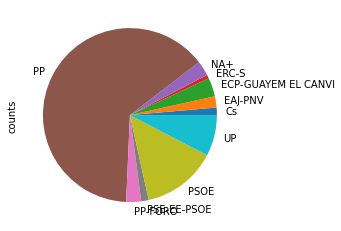

In [89]:
formaciones.plot.pie(y='counts', legend=False)

In [6]:
fl = df.iloc[4]['freeling'].split('\n')
fl

['Esta este DD0FS0 0.978817',
 'pregunta pregunta NCFS000 0.694581',
 'que que PR0CN00 0.550139',
 'se se P00CN00 0.494509',
 'hace hacer VMIP3S0 1',
 'el el DA0MS0 1',
 'Alcalde_de_Madrid alcalde_de_madrid NP00O00 1',
 'nos nos PP1CP00 0.810258',
 'la lo PP3FSA0 0.010734',
 'hacemos hacer VMIP1P0 1',
 'muchos mucho DI0MP0 0.663994',
 'españoles español NCMP000 0.413379',
 'cada cada DI0CS0 1',
 'vez vez NCFS000 1',
 'que que PR0CN00 0.550139',
 'vemos ver VMIP1P0 1',
 'que que CS 0.449861',
 'los el DA0MP0 0.992728',
 'Bardem bardem NP00SP0 1',
 'se se P00CN00 0.494509',
 'ponen poner VMIP3P0 1',
 'detrás_de detrás_de SP 1',
 'la el DA0FS0 0.98926',
 'correspondiente correspondiente AQ0CS00 0.993421',
 'pancarta pancarta NCFS000 1',
 'progre progre AQ0CS00 0.661293',
 'https://t.co/wB5es3NjSZ https://t.co/wB5es3NjSZ Z 1',
 '. . Fp 1']

## Llevar paraules que no aportin significat

Freeling morfo

https://freeling-user-manual.readthedocs.io/en/v4.2/tagsets/tagset-es/

`Morfo { Word, Lema, PoS_Tag, Probability }`

In [30]:
class Morfo:
    def __init__(self, word, lema, pos, prob):
        self.word = word
        self.lema = lema
        self.pos = pos
        self.prob = prob
        
    def isAdjective(self):
        return self.pos[0] == 'A'
    
    def isConjunction(self):
        return self.pos[0] == 'C'
    
    def isDeterminer(self):
        return self.pos[0] == 'D'
    
    def isNoun(self):
        return self.pos[0] == 'N'
    
    def isPronoun(self):
        return self.pos[0] == 'P'
    
    def isAdverb(self):
        return self.pos[0] == 'R'
    
    def isAdposition(self):
        return self.pos[0] == 'S'
    
    def isVerb(self):
        return self.pos[0] == 'V'
    
    def isNumber(self):
        return self.pos[0] == 'N'
    
    def isDate(self):
        return self.pos[0] == 'D'
    
    def isInterjection(self):
        return self.pos[0] == 'I'
    
    def isPunctuation(self):
        return self.pos[0] == 'F'
    
    def isOther(self):
        return self.pos[0] == 'Z'
    
    def isNonSignificant(self):
        return self.isConjunction() or self.isDeterminer() or self.isPronoun() or self.isAdposition() or self.isOther()
        
    def __str__(self):
        return f'<{self.word}, {self.lema}, {self.pos}, {self.prob}>'
        
def getMorfo(line):
    parts = line.split(' ')
    if len(parts) != 4:
        return None
    return Morfo(parts[0] ,parts[1], parts[2], parts[3])

In [149]:
morfos = [getMorfo(l) for l in fl]
for m in morfos:
    print(m)

None


In [118]:
morfos_no_conj = [m for m in morfos if not m.isConjunction()]
for m in morfos_no_conj:
    print(m)

<Esta, este, DD0FS0, 0.978817>
<pregunta, pregunta, NCFS000, 0.694581>
<que, que, PR0CN00, 0.550139>
<se, se, P00CN00, 0.494509>
<hace, hacer, VMIP3S0, 1>
<el, el, DA0MS0, 1>
<Alcalde_de_Madrid, alcalde_de_madrid, NP00O00, 1>
<nos, nos, PP1CP00, 0.810258>
<la, lo, PP3FSA0, 0.010734>
<hacemos, hacer, VMIP1P0, 1>
<muchos, mucho, DI0MP0, 0.663994>
<españoles, español, NCMP000, 0.413379>
<cada, cada, DI0CS0, 1>
<vez, vez, NCFS000, 1>
<que, que, PR0CN00, 0.550139>
<vemos, ver, VMIP1P0, 1>
<los, el, DA0MP0, 0.992728>
<Bardem, bardem, NP00SP0, 1>
<se, se, P00CN00, 0.494509>
<ponen, poner, VMIP3P0, 1>
<detrás_de, detrás_de, SP, 1>
<la, el, DA0FS0, 0.98926>
<correspondiente, correspondiente, AQ0CS00, 0.993421>
<pancarta, pancarta, NCFS000, 1>
<progre, progre, AQ0CS00, 0.661293>
<https://t.co/wB5es3NjSZ, https://t.co/wB5es3NjSZ, Z, 1>
<., ., Fp, 1>


In [119]:
morfos_no_conj_det = [m for m in morfos_no_conj if not m.isDeterminer()]
for m in morfos_no_conj_det:
    print(m)

<pregunta, pregunta, NCFS000, 0.694581>
<que, que, PR0CN00, 0.550139>
<se, se, P00CN00, 0.494509>
<hace, hacer, VMIP3S0, 1>
<Alcalde_de_Madrid, alcalde_de_madrid, NP00O00, 1>
<nos, nos, PP1CP00, 0.810258>
<la, lo, PP3FSA0, 0.010734>
<hacemos, hacer, VMIP1P0, 1>
<españoles, español, NCMP000, 0.413379>
<vez, vez, NCFS000, 1>
<que, que, PR0CN00, 0.550139>
<vemos, ver, VMIP1P0, 1>
<Bardem, bardem, NP00SP0, 1>
<se, se, P00CN00, 0.494509>
<ponen, poner, VMIP3P0, 1>
<detrás_de, detrás_de, SP, 1>
<correspondiente, correspondiente, AQ0CS00, 0.993421>
<pancarta, pancarta, NCFS000, 1>
<progre, progre, AQ0CS00, 0.661293>
<https://t.co/wB5es3NjSZ, https://t.co/wB5es3NjSZ, Z, 1>
<., ., Fp, 1>


In [120]:
morfos_no_conj_det_pun = [m for m in morfos_no_conj_det if not m.isPunctuation()]
for m in morfos_no_conj_det_pun:
    print(m)

<pregunta, pregunta, NCFS000, 0.694581>
<que, que, PR0CN00, 0.550139>
<se, se, P00CN00, 0.494509>
<hace, hacer, VMIP3S0, 1>
<Alcalde_de_Madrid, alcalde_de_madrid, NP00O00, 1>
<nos, nos, PP1CP00, 0.810258>
<la, lo, PP3FSA0, 0.010734>
<hacemos, hacer, VMIP1P0, 1>
<españoles, español, NCMP000, 0.413379>
<vez, vez, NCFS000, 1>
<que, que, PR0CN00, 0.550139>
<vemos, ver, VMIP1P0, 1>
<Bardem, bardem, NP00SP0, 1>
<se, se, P00CN00, 0.494509>
<ponen, poner, VMIP3P0, 1>
<detrás_de, detrás_de, SP, 1>
<correspondiente, correspondiente, AQ0CS00, 0.993421>
<pancarta, pancarta, NCFS000, 1>
<progre, progre, AQ0CS00, 0.661293>
<https://t.co/wB5es3NjSZ, https://t.co/wB5es3NjSZ, Z, 1>


In [121]:
morfos_no_conj_det_pun_other = [m for m in morfos_no_conj_det_pun if not m.isOther()]
for m in morfos_no_conj_det_pun_other:
    print(m)

<pregunta, pregunta, NCFS000, 0.694581>
<que, que, PR0CN00, 0.550139>
<se, se, P00CN00, 0.494509>
<hace, hacer, VMIP3S0, 1>
<Alcalde_de_Madrid, alcalde_de_madrid, NP00O00, 1>
<nos, nos, PP1CP00, 0.810258>
<la, lo, PP3FSA0, 0.010734>
<hacemos, hacer, VMIP1P0, 1>
<españoles, español, NCMP000, 0.413379>
<vez, vez, NCFS000, 1>
<que, que, PR0CN00, 0.550139>
<vemos, ver, VMIP1P0, 1>
<Bardem, bardem, NP00SP0, 1>
<se, se, P00CN00, 0.494509>
<ponen, poner, VMIP3P0, 1>
<detrás_de, detrás_de, SP, 1>
<correspondiente, correspondiente, AQ0CS00, 0.993421>
<pancarta, pancarta, NCFS000, 1>
<progre, progre, AQ0CS00, 0.661293>


In [122]:
morfos_no_conj_det_pun_other_pron = [m for m in morfos_no_conj_det_pun_other if not m.isPronoun()]
for m in morfos_no_conj_det_pun_other_pron:
    print(m)

<pregunta, pregunta, NCFS000, 0.694581>
<hace, hacer, VMIP3S0, 1>
<Alcalde_de_Madrid, alcalde_de_madrid, NP00O00, 1>
<hacemos, hacer, VMIP1P0, 1>
<españoles, español, NCMP000, 0.413379>
<vez, vez, NCFS000, 1>
<vemos, ver, VMIP1P0, 1>
<Bardem, bardem, NP00SP0, 1>
<ponen, poner, VMIP3P0, 1>
<detrás_de, detrás_de, SP, 1>
<correspondiente, correspondiente, AQ0CS00, 0.993421>
<pancarta, pancarta, NCFS000, 1>
<progre, progre, AQ0CS00, 0.661293>


In [138]:
significant_lemas = [m.lema for m in morfos if not m.isNonSignificant()]
for lema in significant_lemas:
    print(lema)

pregunta
hacer
alcalde_de_madrid
hacer
español
vez
ver
bardem
poner
detrás_de
correspondiente
pancarta
progre
.


In [8]:
fl = df.iloc[0]['freeling'].split('\n')
fl

['FL-SERVER-READY']

In [31]:
morfos = [getMorfo(l) for l in fl if getMorfo(l) != None]
morfos

[]

In [32]:
def getSignificantLemas(freeling, withoutPunctuation=False):
    morfos = [getMorfo(l) for l in freeling.split('\n') if getMorfo(l) != None]
    morfos = [m for m in morfos if not m.isNonSignificant()]
    if withoutPunctuation:
        morfos = [m for m in morfos if not m.isPunctuation()]
    return [m.lema for m in morfos]

df['significantLemas'] = df.apply(lambda x: getSignificantLemas(x['freeling']), axis = 1)

In [33]:
df.head()

,_id,_type,_index,id,text,freeling,created_at,diputado.apellidos,diputado.codParlamentario,diputado.formacion,diputado.genero,diputado.grupo,diputado.idCircunscripcion,diputado.nombreCircunscripcion,significantLemas
0,B-0To3gBIirSknWccxlR,_doc,tfg-tweets,1203141389346840576,https://t.co/ppNoPWbdbj,FL-SERVER-READY,2019-12-07T02:37:15.000Z,Antonio,372,PSOE,1,Grupo Parlamentario Socialista,14,Córdoba,[]
1,CO0To3gBIirSknWcdBli,_doc,tfg-tweets,1203238410128891905,"Un mes de la Prep, la pastilla que evita la tr...",Un uno DI0MS0 0.99698\nmes mes NCMS000 1\nde d...,2019-12-07T09:02:46.000Z,Antonio,372,PSOE,1,Grupo Parlamentario Socialista,14,Córdoba,"[mes, prep, ,, pastilla, evitar, transmisión, ..."
2,Ce0To3gBIirSknWcdRlL,_doc,tfg-tweets,1203239323581194245,Una multitudinaria Marcha por el Clima arranca...,Una uno DI0FS0 0.951973\nmultitudinaria multit...,2019-12-07T09:06:24.000Z,Antonio,372,PSOE,1,Grupo Parlamentario Socialista,14,Córdoba,"[multitudinario, marcha, clima, arrancar, madr..."
3,Cu0To3gBIirSknWcdhkh,_doc,tfg-tweets,1203249204581294080,Un honor ser vuestro compañero https://t.co/PM...,FL-SERVER-READY,2019-12-07T09:45:40.000Z,Juan Antonio,35,PP,1,Grupo Parlamentario Popular en el Congreso,13,Ciudad Real,[]
4,C-0To3gBIirSknWcdxkv,_doc,tfg-tweets,1203296764650020864,Esta pregunta que se hace el Alcalde de Madrid...,Esta este DD0FS0 0.978817\npregunta pregunta N...,2019-12-07T12:54:39.000Z,Marta,237,PP,2,Grupo Parlamentario Popular en el Congreso,15,Coruña (A),"[pregunta, hacer, alcalde_de_madrid, hacer, es..."


In [34]:
df['significantLemas']

0                                                     []
1      [mes, prep, ,, pastilla, evitar, transmisión, ...
2      [multitudinario, marcha, clima, arrancar, madr...
3                                                     []
4      [pregunta, hacer, alcalde_de_madrid, hacer, es...
                             ...                        
139                                                  [.]
140                                                  [.]
141                                                  [.]
142                                                  [.]
143                                                  [.]
Name: significantLemas, Length: 144, dtype: object

In [35]:
itemsLemas = df.apply(lambda x: getSignificantLemas(x['freeling'], withoutPunctuation=True), axis = 1)
itemsLemas



0                                                     []
1      [mes, prep, pastilla, evitar, transmisión, vih...
2      [multitudinario, marcha, clima, arrancar, madr...
3                                                     []
4      [pregunta, hacer, alcalde_de_madrid, hacer, es...
                             ...                        
139                                                   []
140                                                   []
141                                                   []
142                                                   []
143                                                   []
Length: 144, dtype: object

In [39]:
from collections import Counter

lemas = []
for il in itemsLemas:
    for l in il:
        lemas.append(l)

counter = Counter(lemas)
counter.most_common(10)

[('ser', 32),
 ('haber', 27),
 ('estar', 17),
 ('constitución', 17),
 ('hoy', 16),
 ('españa', 16),
 ('hacer', 9),
 ('poder', 9),
 ('más', 9),
 ('tener', 8)]